In [1]:
import numpy as np
import math
from scipy.optimize import minimize  

# Accelerated Gradient Sliding

##### Gradient Method for Composite Optimization
 

$\phi_{i}(y) := \langle \nabla h(y^{k}), \, y - y^{k} \rangle + g(y) + \tfrac{L_h}{2} \|y - y^{k}\|_2^2 + \tfrac{L}{2} \|y - y^{0}\|_2^2$

In [182]:
# Psi function
# Input parameters:
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# yk --- y^{k}
# L_h  --- Lipchitz for h(x)

def orac_psi(x, p_grad_h, p_g, Lh, yk, L, y0):
    
    nor1 = np.linalg.norm(x - yk, 2)
    nor_sq1 = nor1*nor1

    nor2 = np.linalg.norm(x - y0, 2)
    nor_sq2 = nor2*nor2
    
    
    #print('ttt', p_grad_h(yk).shape, yk.shape, x.shape)
    #print('oo ', x.shape, p_g(x), np.dot(p_grad_h(yk).T, x - yk))
    return float(np.dot(p_grad_h(yk).T, x - yk)) + p_g(x) + Lh / 2 * nor_sq1 + L / 2 * nor_sq2


# Gradient Method for Composite Optimization
# Input parameters:
# p_orac_psi --- oracle for Minimization Alg
# p_grad_h --- pointer on \nabla h(x) function
# p_g --- pointer on \tilde g(x) function
# y0 --- y^0 (first initial point for minimize)
# L_h  --- Lipchitz for h(x)
# N --- number of iterations
# xk1 --- $x^{k+1}$

def GradComposite(p_orac_psi, p_grad_h, p_g, Lh, y0, N, L, xk1, p_grad_g, eps):
    
    yi = np.copy(xk1)
    
    nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi), 2)
    nor2_krit = 0
    
    i = 0
    
    while True:#for i in range(0, N):
        
        i = i + 1
        
        allargs = (p_grad_h, p_g, Lh, yi, L, y0)
        
        minim_res = minimize(p_orac_psi, args = allargs, x0 = np.ravel(yi), tol = eps, options={'maxiter': 10, 'disp': True})
        
        yi = (minim_res.x)#.reshape(n_dim, 1)
        
        nor1_krit = np.linalg.norm(p_grad_g(yi) + p_grad_h(yi) + L*(yi - y0), 2)
        nor2_krit = np.linalg.norm(yi - y0, 2)
        
        print('Comp', i, nor1_krit)  
        
        if nor1_krit <= L / 2 * nor2_krit:
            break
        
        if i > 2:
            break
    
    return yi#sum_y / N

#### Monteiro–Svaiter Accelerated Proximal method
Parameters:  
$L > 0$    
$x0$ --- initial point  
$N$ --- number of iterations  
$type\_z\_step$ --- 1 -- stardard version for calculating $z$, 2 -- experimental version for calculating $z$ (without gradient of $f(x)$)   

In [183]:
def ms_acc_prox_method(L, Lh, x0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, eps, verbose = 0):

    # Initial points
    y0 = np.copy(x0)
    z0 = np.copy(x0)

    it = 0

    x = x0
    y = y0
    z = z0

    plt1 = []
    
    Ak = 0
    
    while  it < N: 
        it = it + 1
        
        ak = (1/L + math.sqrt(1/L/L + 4 * Ak / L)) / 2
        Ak1 = Ak + ak
        
        x = Ak / Ak1 * y + ak / Ak1 * z
        
        #print('mm', x.shape, y.shape, z.shape)
        y = GradComposite(orac_psi, p_grad_h, p_g, Lh, x, N, L, x, p_grad_g, eps)
        
        if type_z_step == 1:
            z = z - ak * (p_grad_h(y) + p_grad_g(y))
        elif type_z_step == 2:    
            z = z - ak * L * (x - y)
        
        if verbose == 1:
            print("x y z ak Ak Ak+1", x.shape, y.shape, z.shape, ak, Ak, Ak1)
        
        Ak = Ak1
     

        
        if verbose == 1:
            print('Main loop: iter f(y)')

        plt1.append(p_f(y))
        
        if verbose == 1:
            print(it, p_f(y))
        
    return N, y, plt1

##### Restarts for MS

In [5]:
def ms_restarts(mu, L, Lh, eta0, N, p_grad_h, p_g, p_grad_g, p_f, type_z_step, verbose = 0):
    
    N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, verbose = 1)
    

#### Case 1. Kernel SVM

In [6]:
import pandas as pd
# Load data from a csv file
bcdf = pd.read_csv('breast-cancer-wisconsin.data', header = None)

# Drop unecessary columns
bcdf.drop([0], axis = 1, inplace = True)

print(bcdf.size)
bcdf.replace('?', np.nan, inplace = True)
bcdf.dropna(inplace = True)
print(bcdf.size)

bcdf[10].replace(2, 1, inplace = True)
bcdf[10].replace(4, -1, inplace = True)

bcdf = bcdf.apply(pd.to_numeric, errors = 'ignore')
bcdf.info()

6990
6830
<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 0 to 698
Data columns (total 10 columns):
1     683 non-null int64
2     683 non-null int64
3     683 non-null int64
4     683 non-null int64
5     683 non-null int64
6     683 non-null int64
7     683 non-null int64
8     683 non-null int64
9     683 non-null int64
10    683 non-null int64
dtypes: int64(10)
memory usage: 58.7 KB


In [7]:
bcdf.groupby(10).mean()

,1,2,3,4,5,6,7,8,9
10,,,,,,,,,
-1,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510
1,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315


In [8]:
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Split data into testing and training set. Use 67% for training
X_train, X_test, y_train, y_test = train_test_split(bcdf.iloc[:,:-1], bcdf[10], train_size = .67)

# Instantiate 
norm = Normalizer()

# Fit
norm.fit(X_train)

# Transform both training and testing sets
X_train_norm = norm.transform(X_train)
X_test_norm = norm.transform(X_test)

SVM_params = {'C':[0.001, 0.1, 10, 100], 'kernel':['rbf' ,'linear', 'poly', 'sigmoid']}

kfold = KFold(n_splits = 5, shuffle = True)#, random_state = 42)

model_grid = GridSearchCV(SVC(), SVM_params)

cv_results = cross_val_score(model_grid, X_train_norm, y_train, cv = kfold, scoring = 'accuracy')

msg = "Cross Validation Accuracy %s: Accuracy: %f SD: %f" % ('SVM sklearn', cv_results.mean(), cv_results.std())

print(msg)

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will ch

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

Cross Validation Accuracy SVM sklearn: Accuracy: 0.881892 SD: 0.027866


C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\Jane\AnacondaPython\lib\site-packages\sklearn\svm\base.py:

$$
\min_{\beta_0, \, \beta} \sum_{i = 1}^n [1 - y_i (\beta_0 + \beta x_i)]_+ + \frac{\lambda}{2} \| \beta \|_2
$$

$$
\min_{\beta_0, \, \theta} L[y, \, K \theta] + \frac{\lambda}{2} \theta^T K \theta
$$

$K$ is $n \times n$ matrix, $K(x, x') = \exp(-\gamma \|x - x' \|^2)$

In [9]:
pd.to_numeric(X_train[6])

45      1
282    10
583     1
694     2
350     1
417     1
661     1
634     1
108     1
535     1
171     1
471     1
373     1
440    10
128    10
217     1
172     1
331     1
318     1
204     1
52      5
264     3
458     1
670     8
393     1
422     1
480     1
447     1
61      2
443     2
       ..
39      7
86      8
638     1
200    10
361    10
284    10
468     1
627     5
542     1
156     1
234     1
251    10
115     5
38     10
188     8
120     1
389     2
28      1
116     2
209     1
463     1
59      2
692     1
550     1
511     1
454     1
375     1
97      1
339    10
312     1
Name: 6, Length: 457, dtype: int64

In [171]:
# Oracles

# h(x) is strongly convex

lam = 0.2
gamma = 1

n_sam = X_train.values.shape[0]
X_arr = X_train.values
y_arr = y_train.values.reshape(n_sam, 1)

def K_func(xi, xj):
    nor = np.linalg.norm(xi - xj, 2)
    #xi = xi.reshape(xi.shape[0], 1)
    #r = np.dot(xi.T, xj)
    #return (1+r)*(1+r)
    return np.exp(-gamma * nor * nor)

K_matrix = np.zeros((n_sam, n_sam))
E_matrix = np.identity(n_sam)
for i in range(0, n_sam):
    for j in range(0, n_sam):
        K_matrix[i][j] = K_func(X_arr[i, :], X_arr[j, :])

def h1(btheta):
    theta = btheta[1:] #bnorm = np.linalg.norm(beta[1:])
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    #print('h1', lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta))))
    return lam / 2 * float(np.dot(theta.T, np.dot(K_matrix, theta)))

def grad_h1(btheta):
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    gr = lam*np.dot(K_matrix, theta)
    #print('gr', gr.shape)
    gr0 = np.insert(gr, 0, 0)#, axis = 0)
    #print('gr h1', gr0.shape, np.linalg.norm(gr), gr[3], theta[3])
    return gr0 

def g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    #theta = theta.reshape(n_dim, 1)
    
    beta0 = btheta[0]
    
    s2 = 0
    
    for i in range(0, n_dim):
                      
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        if ty <= 0:
            pos = 0.5 - ty
        elif ty <= 1:
            pos = 0.5 * (1 - ty) * (1 - ty)
        else:
            pos = 0
        s2 = s2 + pos  
        
    return float(s2)

def grad_g1(btheta):
    
    theta = btheta[1:]
    n_dim = theta.shape[0]
    theta = theta.reshape(n_dim, 1)
    beta0 = btheta[0]
    
    gr = np.zeros(btheta.shape)#.reshape(n_dim, 1)    
        
    sum_for_beta0 = 0
    sum_for_beta = 0
    for i in range(0, n_dim):
        #print(theta.T.shape, K_matrix[i, :].reshape(n_dim, 1).shape)
        ty = y_arr[i]*(beta0 + float(np.dot(theta.T, K_matrix[i, :].reshape(n_dim, 1))))
        ty = float(ty)
        if ty <= 0:
            for_beta0 = float(-y_arr[i])
            for_beta = for_beta0*K_matrix[i, :]
            #print(ty, for_beta0.shape, for_beta.shape)
        elif ty <= 1:
            for_beta0 = float((1 - ty) * (-y_arr[i]))
            for_beta = for_beta0*K_matrix[i, :]
        else:
            for_beta0 = 0
            for_beta = np.zeros(theta.shape[0])
            
        sum_for_beta0 = sum_for_beta0 + for_beta0
        sum_for_beta = sum_for_beta + for_beta
        #print(i, ty, sum_for_beta0, sum_for_beta.shape, np.linalg.norm(sum_for_beta))
    gr[0] = sum_for_beta0
    gr[1:] = sum_for_beta
    
    return gr
    
def f1(x):
    return h1(x) + g1(x)

In [159]:
n_sam = X_arr.shape[0]
n = 10
x0 = 10*np.random.rand(n_sam + 1)
L = 1
Lh = 1

eps = 1e-1
mu = 1

norm_x0 = np.linalg.norm(x0, 2)
s = sum([np.linalg.norm(X_arr[i], 2) for i in range(0, n_sam)])
norm_opt = min([1 / n_sam / lam*s, math.sqrt(2/lam)])
norm_x0


T = math.log((norm_x0*norm_x0 + norm_opt*norm_opt + 2*norm_x0*norm_opt) * mu / eps)

N0 = math.sqrt(8 * L / mu)
N0

2.8284271247461903

In [184]:
N = 50

N1, y1, plt1 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 1, eps, verbose = 1)

print('----------------------------------------------------------------')
N2, y2, plt2 = ms_acc_prox_method(L, Lh, x0, N, grad_h1, g1, grad_g1, f1, 2, eps, verbose = 1)

print('Answer 1: ', N1, f1(y1))
print('Answer 2: ', N2, f1(y2))

minimize start (458,) (458,)
         Current function value: -14279.851536
         Iterations: 10
         Function evaluations: 8280
         Gradient evaluations: 18
Comp 1 213.46750588442725
minimize start (458,) (458,)
         Current function value: 2112.168892
         Iterations: 10
         Function evaluations: 5980
         Gradient evaluations: 13
Comp 2 44.42424657090275
minimize start (458,) (458,)
         Current function value: 1600.118485
         Iterations: 10
         Function evaluations: 5980
         Gradient evaluations: 13
Comp 3 45.38535531343966
x y z ak Ak Ak+1 (458,) (458,) (458,) 1.0 0 1.0
Main loop: iter f(y)
1 1511.3650924920562
minimize start (458,) (458,)
         Current function value: -829.017502
         Iterations: 10
         Function evaluations: 8740
         Gradient evaluations: 19
Comp 1 62.769513844349575
minimize start (458,) (458,)
         Current function value: 154.729783
         Iterations: 10
         Function evaluations: 6440
 

         Current function value: 3.297620
         Iterations: 10
         Function evaluations: 6440
         Gradient evaluations: 14
Comp 3 1.3581867708001871
x y z ak Ak Ak+1 (458,) (458,) (458,) 5.942116580237086 29.3666328728914 35.308749453128485
Main loop: iter f(y)
10 21.734781945742053
minimize start (458,) (458,)
         Current function value: -0.312186
         Iterations: 10
         Function evaluations: 7820
         Gradient evaluations: 17
Comp 1 9.49708334694335
minimize start (458,) (458,)
         Current function value: 0.906008
         Iterations: 10
         Function evaluations: 8740
         Gradient evaluations: 19
Comp 2 2.875610431951399
minimize start (458,) (458,)
         Current function value: 3.695185
         Iterations: 10
         Function evaluations: 6900
         Gradient evaluations: 15
Comp 3 0.7135265599153273
x y z ak Ak Ak+1 (458,) (458,) (458,) 6.463115750438565 35.308749453128485 41.771865203567046
Main loop: iter f(y)
11 21.46660339783

         Current function value: 1.340004
         Iterations: 10
         Function evaluations: 9660
         Gradient evaluations: 21
Comp 1 6.086835089549135
minimize start (458,) (458,)
         Current function value: 2.670384
         Iterations: 10
         Function evaluations: 6440
         Gradient evaluations: 14
Comp 2 2.072098019019231
minimize start (458,) (458,)
         Current function value: 2.897485
         Iterations: 10
         Function evaluations: 7360
         Gradient evaluations: 16
Comp 3 0.7192933110019895
x y z ak Ak Ak+1 (458,) (458,) (458,) 11.098240681522615 112.07270554348094 123.17094622500355
Main loop: iter f(y)
20 19.71687461934085
minimize start (458,) (458,)
         Current function value: 4.604659
         Iterations: 10
         Function evaluations: 9660
         Gradient evaluations: 21
Comp 1 8.56803972605323
minimize start (458,) (458,)
         Current function value: 0.309289
         Iterations: 10
         Function evaluations: 8280
 

Optimization terminated successfully.
         Current function value: 2.842663
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 3 0.3419587941654564
x y z ak Ak Ak+1 (458,) (458,) (458,) 15.684704560084912 230.3252525770635 246.00995713714843
Main loop: iter f(y)
29 19.686219659441832
minimize start (458,) (458,)
         Current function value: 2.815365
         Iterations: 10
         Function evaluations: 6440
         Gradient evaluations: 14
Comp 1 3.63104153772437
minimize start (458,) (458,)
         Current function value: 2.344503
         Iterations: 10
         Function evaluations: 7820
         Gradient evaluations: 17
Comp 2 2.535855021511171
minimize start (458,) (458,)
         Current function value: 2.817432
         Iterations: 10
         Function evaluations: 7360
         Gradient evaluations: 16
Comp 3 0.5512925239828527
x y z ak Ak Ak+1 (458,) (458,) (458,) 16.192672084038094 246.00995713714843 262.2026292211865
Ma

         Current function value: 3.327565
         Iterations: 10
         Function evaluations: 8740
         Gradient evaluations: 19
Comp 1 5.4786219021547184
minimize start (458,) (458,)
         Current function value: 0.129526
         Iterations: 10
         Function evaluations: 7360
         Gradient evaluations: 16
Comp 2 3.85623132793327
minimize start (458,) (458,)
         Current function value: 2.914440
         Iterations: 10
         Function evaluations: 7820
         Gradient evaluations: 17
Comp 3 1.6645528908480463
x y z ak Ak Ak+1 (458,) (458,) (458,) 20.75472183409963 410.0037565767523 430.758478410852
Main loop: iter f(y)
39 19.694065755995204
minimize start (458,) (458,)
         Current function value: 12.801744
         Iterations: 10
         Function evaluations: 5520
         Gradient evaluations: 12
Comp 1 26.11996964138469
minimize start (458,) (458,)
         Current function value: -54.636977
         Iterations: 10
         Function evaluations: 6900


         Current function value: 9.034770
         Iterations: 10
         Function evaluations: 6900
         Gradient evaluations: 15
Comp 3 10.303124869032516
x y z ak Ak Ak+1 (458,) (458,) (458,) 25.304269652587458 615.0017929982711 640.3060626508585
Main loop: iter f(y)
48 19.99806254969956
minimize start (458,) (458,)
         Current function value: -200.627365
         Iterations: 10
         Function evaluations: 9200
         Gradient evaluations: 20
Comp 1 110.50681954711773
minimize start (458,) (458,)
         Current function value: 44.530247
         Iterations: 10
         Function evaluations: 7820
         Gradient evaluations: 17
Comp 2 13.25258524855213
minimize start (458,) (458,)
         Current function value: 43.325902
         Iterations: 10
         Function evaluations: 6440
         Gradient evaluations: 14
Comp 3 2.848187538281422
x y z ak Ak Ak+1 (458,) (458,) (458,) 25.809209048306084 640.3060626508585 666.1152716991646
Main loop: iter f(y)
49 26.3564974

         Current function value: 4.777997
         Iterations: 10
         Function evaluations: 6440
         Gradient evaluations: 14
Comp 1 1.9530363878366146
minimize start (458,) (458,)
         Current function value: 4.193192
         Iterations: 10
         Function evaluations: 5980
         Gradient evaluations: 13
Comp 2 1.760070945958457
minimize start (458,) (458,)
         Current function value: 4.069219
         Iterations: 10
         Function evaluations: 6900
         Gradient evaluations: 15
Comp 3 0.5283030276285501
x y z ak Ak Ak+1 (458,) (458,) (458,) 4.893621764530201 19.053912209753477 23.94753397428368
Main loop: iter f(y)
8 20.66302246319731
minimize start (458,) (458,)
         Current function value: 3.463914
         Iterations: 10
         Function evaluations: 6900
         Gradient evaluations: 15
Comp 1 0.8987115334480588
minimize start (458,) (458,)
         Current function value: 3.317735
         Iterations: 10
         Function evaluations: 6440
 

Optimization terminated successfully.
         Current function value: 2.799650
         Iterations: 9
         Function evaluations: 5980
         Gradient evaluations: 13
Comp 1 0.5402725133058677
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.788386
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 2 0.5402725133058677
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.788386
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 3 0.5402725133058677
x y z ak Ak Ak+1 (458,) (458,) (458,) 10.074039201951415 91.4122266405025 101.48626584245392
Main loop: iter f(y)
18 19.72798287638621
minimize start (458,) (458,)
         Current function value: 2.783859
         Iterations: 10
         Function evaluations: 6900
         Gradient evaluations: 15
Comp 1 0.8017198959155636
minimize start (458,) (

Optimization terminated successfully.
         Current function value: 2.768706
         Iterations: 2
         Function evaluations: 3220
         Gradient evaluations: 7
Comp 1 0.5138387160622396
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.760909
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 2 0.5138387160622396
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.760909
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 3 0.5138387160622396
x y z ak Ak Ak+1 (458,) (458,) (458,) 15.176470359641055 215.14878221742245 230.3252525770635
Main loop: iter f(y)
28 19.715805320988732
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.757402
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 1 0.5033

Optimization terminated successfully.
         Current function value: 2.718387
         Iterations: 2
         Function evaluations: 3220
         Gradient evaluations: 7
Comp 1 0.27645808459705135
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.714893
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 2 0.27645808459705135
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.714893
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 3 0.27645808459705135
x y z ak Ak Ak+1 (458,) (458,) (458,) 20.248549493155117 389.7552070835972 410.0037565767523
Main loop: iter f(y)
38 19.685301366372492
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.709514
         Iterations: 1
         Function evaluations: 1380
         Gradient evaluations: 3
Comp 1 0.2

Optimization terminated successfully.
         Current function value: 2.710183
         Iterations: 2
         Function evaluations: 2760
         Gradient evaluations: 6
Comp 2 0.3635742497894752
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.707011
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 3 0.3635742497894752
x y z ak Ak Ak+1 (458,) (458,) (458,) 25.304269652587458 615.0017929982711 640.3060626508585
Main loop: iter f(y)
48 19.713956875284786
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.717844
         Iterations: 2
         Function evaluations: 3220
         Gradient evaluations: 7
Comp 1 0.507064474281282
minimize start (458,) (458,)
Optimization terminated successfully.
         Current function value: 2.709361
         Iterations: 0
         Function evaluations: 460
         Gradient evaluations: 1
Comp 2 0.50706

<IPython.core.display.Javascript object>


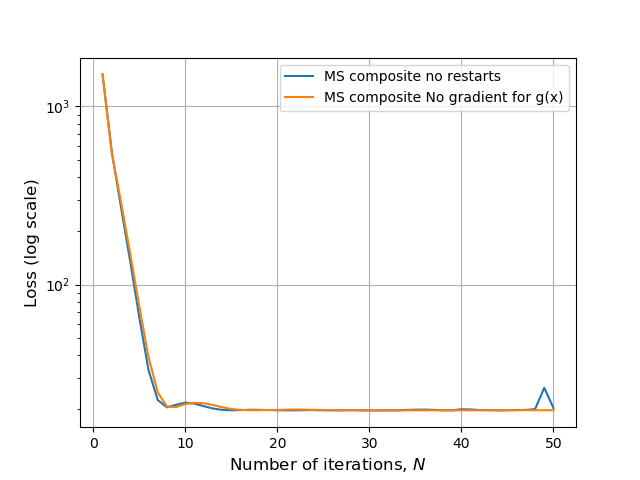

In [188]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.grid(True)
plt.plot(range(1, N1 + 1), plt1, label = 'MS composite no restarts')
plt.plot(range(1, N2 + 1), plt2, label = 'MS composite No gradient for g(x)')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel(r"Number of iterations, $N$", fontsize=12)
plt.ylabel(r"Loss (log scale)", fontsize=12)
#plt.title(r"$m + n = 10, \, \delta = 0.003$", fontsize = 11);
#plt.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2))
plt.legend()